<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Ticket ID                     8469 non-null   int64         
 1   Customer Name                 8469 non-null   object        
 2   Customer Email                8469 non-null   object        
 3   Customer Age                  8469 non-null   int64         
 4   Customer Gender               8469 non-null   object        
 5   Product Purchased             8469 non-null   object        
 6   Date of Purchase              8469 non-null   datetime64[ns]
 7   Ticket Type                   8469 non-null   object        
 8   Ticket Subject                8469 non-null   object        
 9   Ticket Description            8469 non-null   object        
 10  Ticket Status                 8469 non-null   object        
 11  Resolution                    

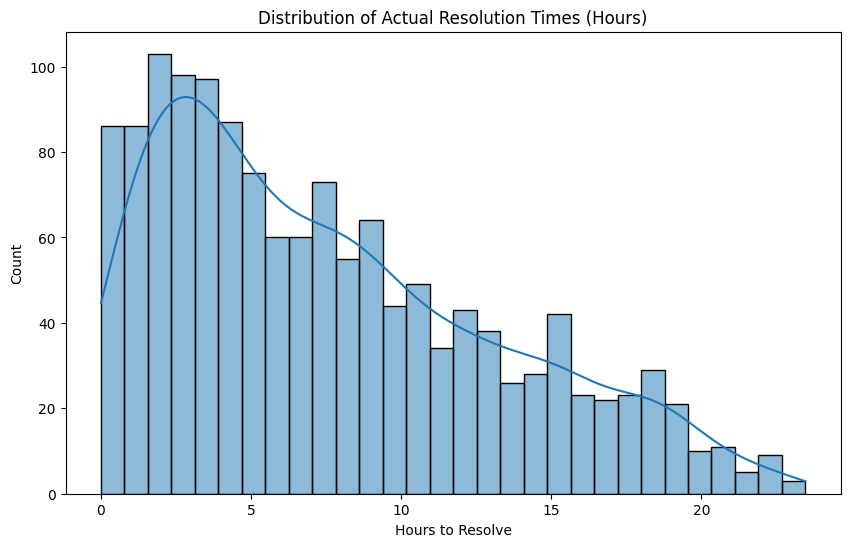

SLA Breach Percentage by Priority:
Ticket Priority
Critical    11.648846
High         0.000000
Low          0.000000
Medium       0.000000
Name: SLA_Breach, dtype: float64


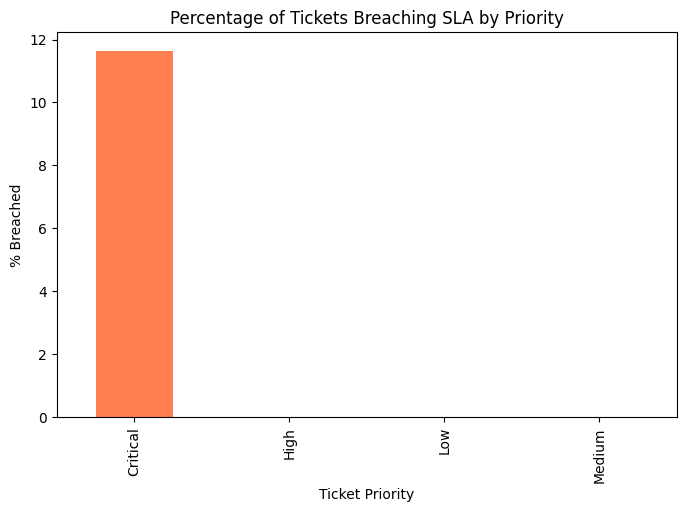

Correlation between Priority and Satisfaction:
                              priority_score  Customer Satisfaction Rating
priority_score                      1.000000                     -0.019934
Customer Satisfaction Rating       -0.019934                      1.000000


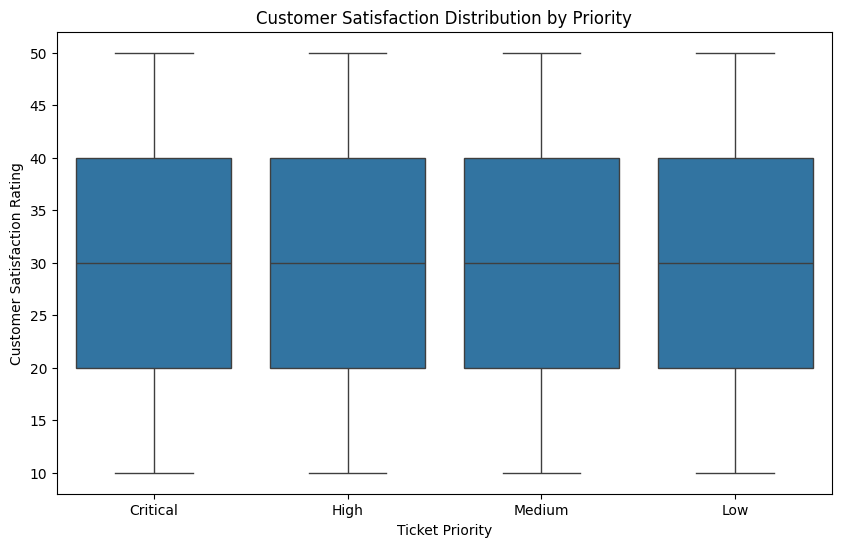

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel('customer_support_ticket.xlsx')

print(df.info())
print(df.head())

df['First Response Time'] = pd.to_datetime(df['First Response Time'], errors='coerce')
df['Time to Resolution'] = pd.to_datetime(df['Time to Resolution'], errors='coerce')

print(f"Missing/Invalid Response Times: {df['First Response Time'].isnull().sum()}")
print(f"Missing/Invalid Resolution Times: {df['Time to Resolution'].isnull().sum()}")

ghost_tickets = df[(df['Ticket Status'] == 'Closed') & (df['Time to Resolution'].isnull())]
print(f"Ghost Tickets Detected: {len(ghost_tickets)}")

df['logic_error'] = df['Time to Resolution'] < df['First Response Time']
time_travelers = df[df['logic_error'] == True]

print(f"Logic Errors (Resolution < Response): {len(time_travelers)}")

clean_df = df[~df['logic_error']].copy()

clean_df['actual_resolution_hours'] = (clean_df['Time to Resolution'] - clean_df['First Response Time']).dt.total_seconds() / 3600

print(clean_df['actual_resolution_hours'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(clean_df['actual_resolution_hours'], bins=30, kde=True)
plt.title('Distribution of Actual Resolution Times (Hours)')
plt.xlabel('Hours to Resolve')
plt.show()

sla_thresholds = {
    'Critical': 5,
    'High': 24,
    'Medium': 48,
    'Low': 72
}

def check_sla(row):
    priority = row['Ticket Priority']
    duration = row['actual_resolution_hours']

    if priority in sla_thresholds:
        if pd.notnull(duration):
            return duration > sla_thresholds[priority]
    return False

clean_df['SLA_Breach'] = clean_df.apply(check_sla, axis=1)

breach_report = clean_df.groupby('Ticket Priority')['SLA_Breach'].mean() * 100
print("SLA Breach Percentage by Priority:")
print(breach_report)

plt.figure(figsize=(8, 5))
breach_report.plot(kind='bar', color='coral')
plt.title('Percentage of Tickets Breaching SLA by Priority')
plt.ylabel('% Breached')
plt.show()

priority_map = {'Critical': 4, 'High': 3, 'Medium': 2, 'Low': 1}
clean_df['priority_score'] = clean_df['Ticket Priority'].map(priority_map)

correlation = clean_df[['priority_score', 'Customer Satisfaction Rating']].corr()
print("Correlation between Priority and Satisfaction:")
print(correlation)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Ticket Priority', y='Customer Satisfaction Rating', data=clean_df, order=['Critical', 'High', 'Medium', 'Low'])
plt.title('Customer Satisfaction Distribution by Priority')
plt.show()